In [151]:
# change dir because notebook is in a child directory of the root directory (and does not find my modules)
import os 
try:
    os.chdir(r'/Users/joan/code/python/jokes-app')
except FileNotFoundError:
    os.chdir(r'/home/repos/joke-app')

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

In [153]:
import src.api.src.db.core as db
try:
    from src.api.src.db.secret import (
        HOST_OVH as HOST, 
        POSTGRES_USER, 
        POSTGRES_PASSWORD_OVH as POSTGRES_PASSWORD, 
        SCHEMA_NAME
    )
except ImportError:
    from src.api.src.db.secret import HOST, POSTGRES_USER, POSTGRES_PASSWORD, SCHEMA_NAME

### Get connection to Postgres DB

In [154]:
conn = db.connect(host=HOST, user=POSTGRES_USER, password=POSTGRES_PASSWORD, schema_name=SCHEMA_NAME)

### Get Number of subscribed users and unsubscribed users

In [155]:
df = db.execute_read(conn, "select * from users_mail")

In [156]:
n_subbed = df["deleted_at"].isna().sum()
n_unsubbed = len(df) - n_subbed

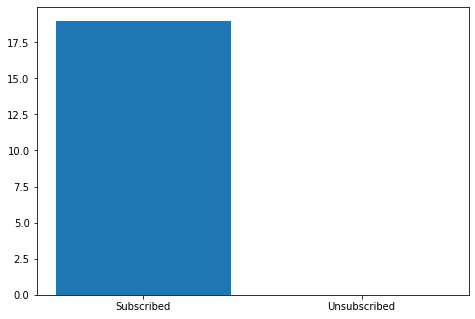

In [157]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l_bars = ['Subscribed', 'Unsubscribed']
ax.bar(l_bars, [n_subbed, n_unsubbed])
plt.show()

### Top 10 Joke reviewers

In [158]:
df_mean_user = db.execute_read(conn, """
select 
	um.email, avg(r.rating), count(r)
from 
	ratings as r
left join users_mail as um
on (r.user_id = um.id_hash)
where "source" = 'mail' and um.email is not null
group by um.email
order by count(r.rating) desc
""")

In [159]:
df_mean_user.head(20)

,email,avg,count
0,watxaut@gmail.com,6.985294,34
1,jaime.conde@ficosa.com,2.019231,26
2,irene.chausse@mosaicfactor.com,5.312500,24
3,antoni.martinezlopez@ficosa.com,2.976190,21
4,Javier.heras@volkswagen-groupservices.com,5.000000,19
5,Extern.javier.gris@seat.es,5.789474,19
6,alex.colomer.puig@gmail.com,3.750000,18
7,guillem.mcid@gmail.com,6.388889,18
8,adria.hr@gmail.com,3.611111,18
9,18mariaff@gmail.com,5.892857,14


## TOP 5 Most Haters (min 5 reviews)

In [160]:
df_mean_user = df_mean_user[df_mean_user["count"] >= 5]
df_mean_user_hater = df_mean_user.sort_values(by=['avg', 'count'])
df_mean_user_hater.head(5)

,email,avg,count
1,jaime.conde@ficosa.com,2.019231,26
3,antoni.martinezlopez@ficosa.com,2.976190,21
8,adria.hr@gmail.com,3.611111,18
6,alex.colomer.puig@gmail.com,3.750000,18
16,marccampmanygarcia@gmail.com,4.000000,5


## TOP 5 Supporters (min 5 reviews)

In [161]:
df_mean_user_supporter = df_mean_user.sort_values(by=['avg', 'count'], ascending=False)
df_mean_user_supporter.head()

,email,avg,count
10,neuscuadernpuig@gmail.com,8.461538,13
15,Miquel.regidor93@gmail.com,8.333333,6
12,ingrid.falguera19@gmail.com,7.954545,11
13,bcocamarin@gmail.com,7.727273,11
0,watxaut@gmail.com,6.985294,34


## AVG joke rating per user

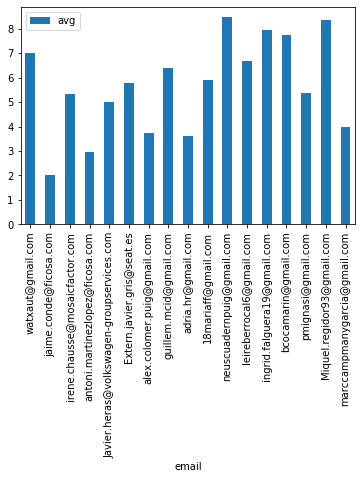

In [162]:
df_mean_user.head(20).plot.bar(x="email", y="avg")

### Rating Statistics

In [163]:
sql = """
select 
	sj.joke_id, r.rating, sj.created_at, r.created_at as voted_at
from
	sent_jokes as sj
left join 
	ratings as r
on 
	(r.joke_id = sj.joke_id)
where 
	r."source" = 'mail'
"""
df_ratings = db.execute_read(conn, sql)

#### Get last 10 ratings

In [164]:
df_ratings.tail(15)

,joke_id,rating,created_at,voted_at
328,1802,5.0,2019-12-01 19:00:05.986648,2019-12-02 07:42:50.697837
329,1802,5.0,2019-12-02 08:30:30.240028,2019-12-02 07:52:58.788852
330,1802,5.0,2019-12-01 19:00:05.986648,2019-12-02 07:52:58.788852
331,1802,7.5,2019-12-02 08:30:30.240028,2019-12-02 07:59:26.836706
332,1802,7.5,2019-12-01 19:00:05.986648,2019-12-02 07:59:26.836706
333,1802,2.5,2019-12-02 08:30:30.240028,2019-12-02 08:00:02.818146
334,1802,2.5,2019-12-01 19:00:05.986648,2019-12-02 08:00:02.818146
335,1802,5.0,2019-12-02 08:30:30.240028,2019-12-02 08:09:06.808938
336,1802,5.0,2019-12-01 19:00:05.986648,2019-12-02 08:09:06.808938
337,1802,5.0,2019-12-02 08:30:30.240028,2019-12-02 08:14:31.636476


## Get mean of ratings by joke and day

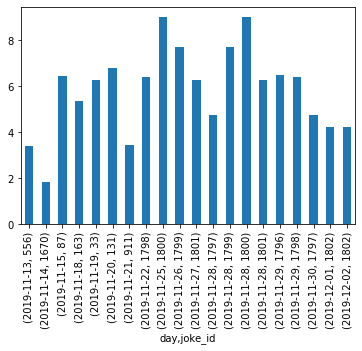

In [165]:
df_ratings["day"] = df_ratings["created_at"].dt.strftime('%Y-%m-%d')
mean_ratings = df_ratings.groupby(["day", "joke_id"])["rating"].mean()
mean_ratings.tail(20).plot.bar(x="day", y="rating")

## Get Std Deviation of ratings by joke and day

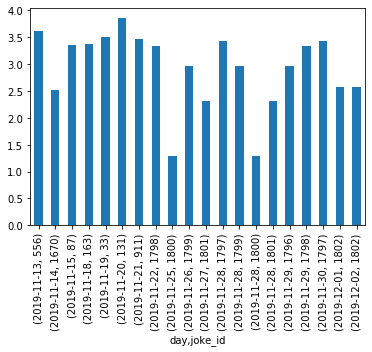

In [166]:
std_ratings = df_ratings.groupby(["day", "joke_id"])["rating"].std()
std_ratings.tail(20).plot.bar(x="day", y="rating")

In [167]:
df_count_ratings = df_ratings.rename(columns={"rating": "count"}).groupby(["day", "joke_id"])["count"].count()
mean_ratings = pd.concat([mean_ratings, df_count_ratings], axis=1)
mean_ratings = mean_ratings[mean_ratings["count"] > 5]

std_ratings = pd.concat([std_ratings, df_count_ratings], axis=1)
std_ratings = std_ratings[std_ratings["count"] > 5]

In [168]:
# get worst and best joke from mean
d_best = mean_ratings.sort_values(ascending=False, by='rating').head(1).to_dict()
s_best_day, best_joke_id = list(d_best["rating"].keys())[0]
d_worst = mean_ratings.sort_values(ascending=False, by='rating').tail(1).to_dict()
s_worst_day, worst_joke_id = list(d_worst["rating"].keys())[0]

df_best = db.execute_read(conn, f"select * from jokes_to_send where id = {best_joke_id}")
df_worst = db.execute_read(conn, f"select * from jokes_to_send where id = {worst_joke_id}")

# get most controversial joke
d_cont = std_ratings.sort_values(ascending=False, by='rating').head(1).to_dict()
s_cont_day, cont_joke_id = list(d_cont["rating"].keys())[0]
df_cont = db.execute_read(conn, f"select * from jokes_to_send where id = {cont_joke_id}")

{'rating': {('2019-11-28', 1800): 9.0}, 'count': {('2019-11-28', 1800): 10}}


## Best joke of all time

In [169]:
print(f"Joke:\n{df_best['joke'][0]}\nAuthor: {df_best['author'][0]}")

Joke:
— ¿Qué es un pez en un cine?

— Un mero espectador
Author: Jokenasi


## Worst joke of all time

In [170]:
print(f"Joke:\n{df_worst['joke'][0]}\nAuthor: {df_worst['author'][0]}")

Joke:
Estos son Zidane i Nhug, nuestros perros de caza... 
.... de caza nueztra.
Author: None


## Most controversial of all time

In [171]:
print(f"Joke:\n{df_cont['joke'][0]}\nAuthor: {df_cont['author'][0]}")

Joke:
¿En qué se parecen un gato, un perro y un hombre ahogado?
En que el gato dice miau, el perro dice guau y el hombre dice: miauguau
Author: The Manlleus
